## Тема: Классификация с помощью kNN. Кластеризация K-means

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

### 1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.

In [2]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)

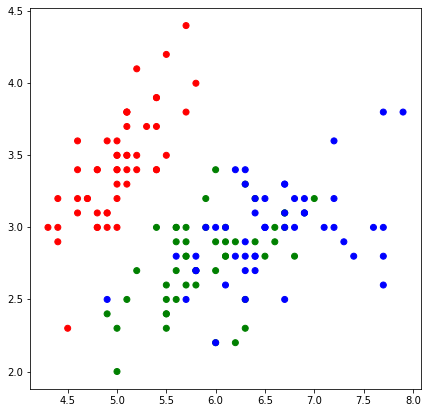

In [4]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap);

In [5]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
        
    distance = np.sum(np.square(x1 - x2))

    return np.sqrt(distance)

In [6]:
def knn(x_train, y_train, x_test, k, q=1):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
            
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            
# ИЗМЕНЕНО
#             classes[d[1]] += 1
            classes[d[1]] += 1/(d[0] + q)
# ИЗМЕНЕНО

        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

In [7]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [8]:
%time
k = 5
y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.53 µs
Точность алгоритма при k = 5: 0.733


In [21]:
%time
k = 5
q = 0.01
y_pred = knn(X_train, y_train, X_test, k, q)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs
Точность алгоритма при k = 5: 0.700


### 2. *Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

In [22]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=100, random_state=1)

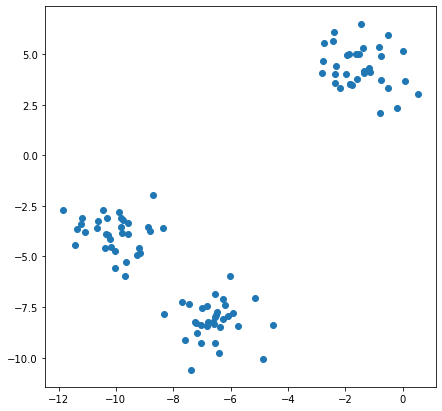

In [23]:
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1]);

In [24]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для кластеризации
    clusters = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # кластеризуем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            cluster = distances.index(min(distances))
            clusters[cluster].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for cluster in clusters:
            centroids[cluster] = np.mean(clusters[cluster], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.linalg.norm(centroids[centroid] - old_centroids[centroid], ord=2) > min_distance:
                optimal = False
                break
        
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, clusters

In [26]:
def visualize(centroids, clusters):
    colors = ['r', 'g', 'b', 'orange', 'y']
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for cluster_item in clusters:
        for x in clusters[cluster_item]:
            plt.scatter(x[0], x[1], color=colors[cluster_item])
            
    plt.show()

In [38]:
# определим максимальное количество итераций
max_iterations = 5

# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4

# сразу определим известное нам количество кластеров
k = 3

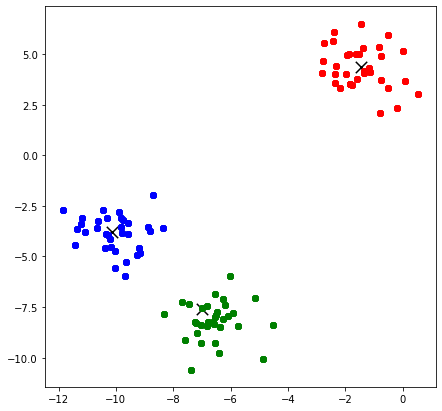

In [39]:
centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

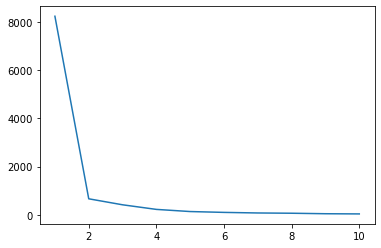

In [83]:
# функция подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и график ее зависимости от количества кластеров k
def avg_squad_distance(centroids, clusters, k):
    sum = 0
    for cluster, data in clusters.items():
        distances = np.array([e_metrics(x, centroids[cluster]) for x in data])
        sum += np.sum(distances ** 2)
    return sum/k

avgs = []
for k in range(1, 11):
    centroids, clusters = kmeans(X, k, max_iterations, min_distance)
    avgs.append([k, avg_squad_distance(centroids, clusters, k)])

plt.plot(np.array(avgs)[:, 0], np.array(avgs)[:, 1])
plt.show()

### 3. *Оптимизировать код для KNN (оставить один цикл, либо обойтись без циклов вообще).

In [45]:
def knn_n(x_train, y_train, x_test, k, q=1):
    
    answers = []
    for x in x_test:
        
# ИЗМЕНЕНО            
        test_distances = list(zip(map(lambda x_t: e_metrics(x, x_t), x_train), y_train))
# ИЗМЕНЕНО

        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:

            classes[d[1]] += 1/(d[0] + q)

        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

In [46]:
%time
k_n = 5
q_n = 0.001
y_pred_n = knn_n(X_train, y_train, X_test, k_n, q_n)

print(f'Точность алгоритма при k = {k_n}: {accuracy(y_pred_n, y_test):.3f}')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.53 µs
Точность алгоритма при k = 5: 0.700
